In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
# import optuna
from tabulate import tabulate
from sklearn.model_selection import StratifiedKFold

 Pour la reproductibilité

In [12]:
np.random.seed(42)

Importation du dataset

In [13]:
dataset = pd.read_csv("data.csv")

#separation des features et de la target
X=dataset.loc[:,dataset.columns !='legitimate']
Y=dataset['legitimate']
print(X.shape)
print(Y.shape)

(137444, 8)
(137444,)


# 2. Division en données d'entraînement et de test

In [14]:

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

print(len(x_train))
print(len(y_train))

96210
96210


Choix du modèle de classification - Decision Tree

# Évaluation du modèle de base

#  Entraînement du modèle avec les données d'entraînement

In [15]:
base_model = DecisionTreeClassifier()
base_model.fit(x_train,y_train)
y_pred = base_model.predict(x_test)

# Calcul des métriques

In [16]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print("\n--- Évaluation du modèle de base ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print("\nMatrice de confusion:")
print(conf_matrix)


--- Évaluation du modèle de base ---
Accuracy: 0.9873
Precision: 0.9874
Recall: 0.9873
F1 Score: 0.9873

Matrice de confusion:
[[28600   284]
 [  238 12112]]


# Visualisation de la matrice de confusion

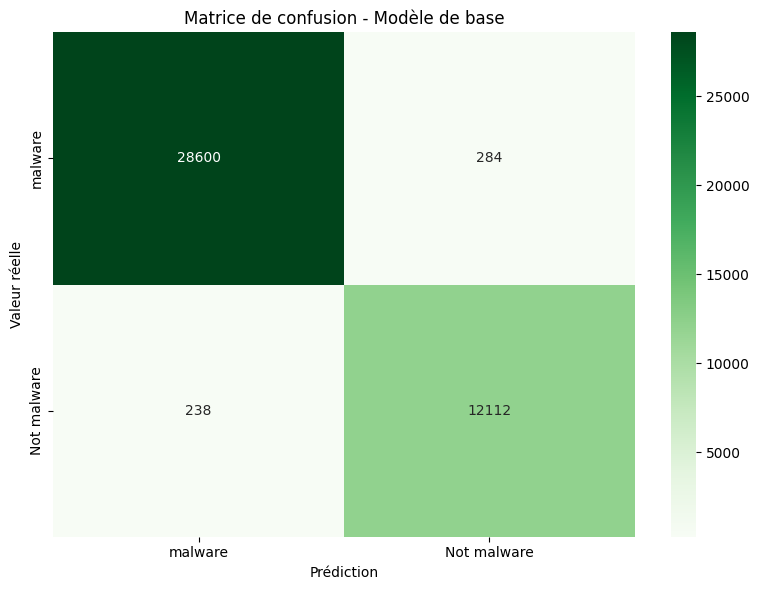

In [17]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=['malware','Not malware'], yticklabels=['malware','Not malware'], cmap='Greens' )
plt.xlabel('Prédiction')
plt.ylabel('Valeur réelle')
plt.title('Matrice de confusion - Modèle de base')
plt.tight_layout()
plt.savefig('base_model_confusion_matrix.png')


# Stockage des résultats de base pour la comparaison finale

In [18]:
base_results = {
    'Méthode': 'Base (sans optimisation)',
    'F1 Score': f1,
    'Precision': precision,
    'Recall': recall,
    'Durée d\'exécution (s)': 0  
}


# Préparation des résultats pour comparaison

In [19]:
all_results = [base_results]

1 Optimisation avec RandomizedSearchCV

# Définition de l'espace de recherche des hyperparamètres pour Decision Tree

In [20]:
param_dist = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 5, 10, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'max_features': [None, 'sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}


# Configuration et exécution de RandomizedSearchCV

In [21]:
random_search = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=20, 
    cv=5,
    scoring='f1_weighted',
    random_state=42,
    n_jobs=-1
)


# Mesure du temps d'exécution

In [22]:
start_time = time.time()
random_search.fit(x_train, y_train)
rs_execution_time = time.time() - start_time

print(f"Meilleurs paramètres trouvés: {random_search.best_params_}")
print(f"Meilleur score de validation: {random_search.best_score_:.4f}")
print(f"Temps d'exécution: {rs_execution_time:.2f} secondes")

Meilleurs paramètres trouvés: {'splitter': 'best', 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 25, 'criterion': 'gini', 'class_weight': 'balanced'}
Meilleur score de validation: 0.9852
Temps d'exécution: 18.72 secondes


# Évaluation du modèle optimisé

In [23]:
best_random_model = random_search.best_estimator_
y_pred_rs = best_random_model.predict(x_test)

rs_accuracy = accuracy_score(y_test, y_pred_rs)
rs_precision = precision_score(y_test, y_pred_rs, average='weighted')
rs_recall = recall_score(y_test, y_pred_rs, average='weighted')
rs_f1 = f1_score(y_test, y_pred_rs, average='weighted')
rs_conf_matrix = confusion_matrix(y_test, y_pred_rs)

print("\nÉvaluation après RandomizedSearchCV:")
print(f"Accuracy: {rs_accuracy:.4f}")
print(f"Precision: {rs_precision:.4f}")
print(f"Recall: {rs_recall:.4f}")
print(f"F1 Score: {rs_f1:.4f}")
print("\nMatrice de confusion:")
print(rs_conf_matrix)


Évaluation après RandomizedSearchCV:
Accuracy: 0.9860
Precision: 0.9861
Recall: 0.9860
F1 Score: 0.9860

Matrice de confusion:
[[28495   389]
 [  190 12160]]


# Visualisation de la matrice de confusion pour RandomizedSearchCV

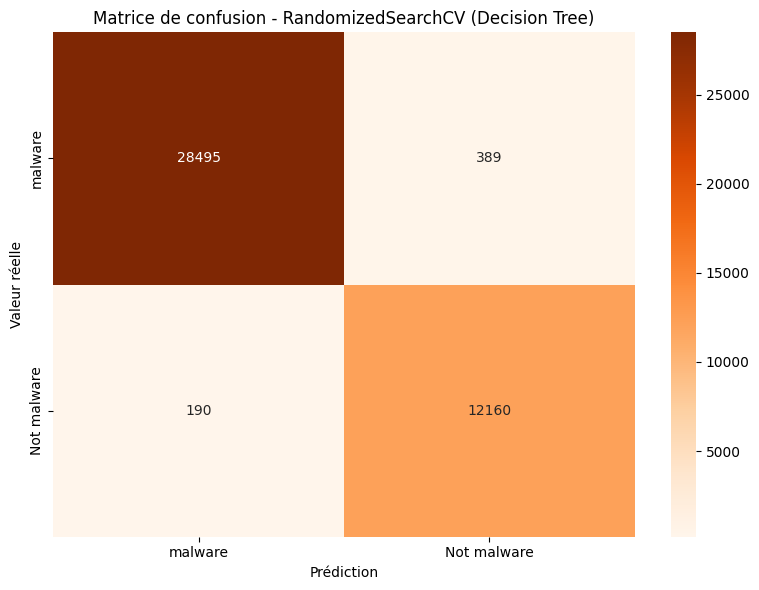

In [24]:
plt.figure(figsize=(8, 6))
sns.heatmap(rs_conf_matrix, annot=True, fmt='d', xticklabels=['malware','Not malware'], yticklabels=['malware','Not malware'], cmap='Oranges' )
plt.xlabel('Prédiction')
plt.ylabel('Valeur réelle')
plt.title('Matrice de confusion - RandomizedSearchCV (Decision Tree)')
plt.tight_layout()
plt.savefig('randomsearch_confusion_matrix.png')


# Ajout des résultats à la liste pour comparaison

In [25]:
all_results.append({
    'Méthode': 'RandomizedSearchCV',
    'F1 Score': rs_f1,
    'Precision': rs_precision,
    'Recall': rs_recall,
    'Durée d\'exécution (s)': rs_execution_time
})

2 Optimisation avec GridSearchCV

# Définition de la grille de recherche pour Decision Tree


In [26]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


# Configuration et exécution de GridSearchCV

In [27]:
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1
)

# Mesure du temps d'exécution

In [28]:
start_time = time.time()
grid_search.fit(x_train, y_train)
gs_execution_time = time.time() - start_time

print(f"Meilleurs paramètres trouvés: {grid_search.best_params_}")
print(f"Meilleur score de validation: {grid_search.best_score_:.4f}")
print(f"Temps d'exécution: {gs_execution_time:.2f} secondes")


Meilleurs paramètres trouvés: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Meilleur score de validation: 0.9867
Temps d'exécution: 39.43 secondes



# Évaluation du modèle optimisé

In [29]:
# Évaluation du modèle optimisé
best_grid_model = grid_search.best_estimator_
y_pred_gs = best_grid_model.predict(x_test)

gs_accuracy = accuracy_score(y_test, y_pred_gs)
gs_precision = precision_score(y_test, y_pred_gs, average='weighted')
gs_recall = recall_score(y_test, y_pred_gs, average='weighted')
gs_f1 = f1_score(y_test, y_pred_gs, average='weighted')
gs_conf_matrix = confusion_matrix(y_test, y_pred_gs)

print("\nÉvaluation après GridSearchCV:")
print(f"Accuracy: {gs_accuracy:.4f}")
print(f"Precision: {gs_precision:.4f}")
print(f"Recall: {gs_recall:.4f}")
print(f"F1 Score: {gs_f1:.4f}")
print("\nMatrice de confusion:")
print(gs_conf_matrix)


Évaluation après GridSearchCV:
Accuracy: 0.9877
Precision: 0.9877
Recall: 0.9877
F1 Score: 0.9877

Matrice de confusion:
[[28603   281]
 [  225 12125]]



# Visualisation de la matrice de confusion pour GridSearchCV

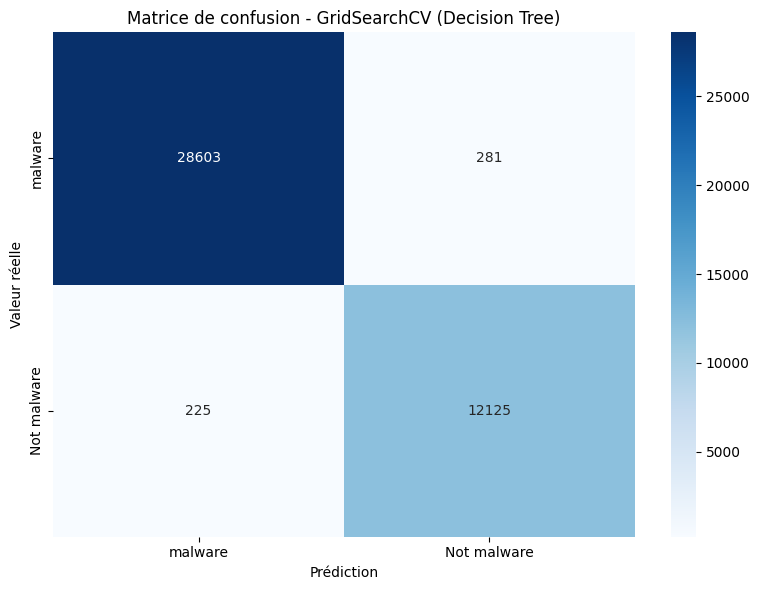

In [30]:
plt.figure(figsize=(8, 6))
sns.heatmap(gs_conf_matrix, annot=True, fmt='d', xticklabels=['malware','Not malware'], yticklabels=['malware','Not malware'], cmap='Blues' )
plt.xlabel('Prédiction')
plt.ylabel('Valeur réelle')
plt.title('Matrice de confusion - GridSearchCV (Decision Tree)')
plt.tight_layout()
plt.savefig('gridsearch_confusion_matrix.png')

# Ajout des résultats à la liste pour comparaison

In [31]:
all_results.append({
    'Méthode': 'GridSearchCV',
    'F1 Score': gs_f1,
    'Precision': gs_precision,
    'Recall': gs_recall,
    'Durée d\'exécution (s)': gs_execution_time
})

3. Optimisation avec Optuna

  # Création du modèle avec les hyperparamètres suggérés

In [32]:
def objective(trial):
    params = {
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'splitter': trial.suggest_categorical('splitter', ['best', 'random']),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 8),
        'max_features': trial.suggest_categorical('max_features', [None, 'sqrt', 'log2'])
    }

    model = DecisionTreeClassifier(**params, random_state=42)

    score = 0
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for train_idx, val_idx in kf.split(x_train, y_train):
        x_train_fold, x_val_fold = x_train.iloc[train_idx], x_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(x_train_fold, y_train_fold)
        y_pred_fold = model.predict(x_val_fold)
        fold_score = f1_score(y_val_fold, y_pred_fold, average='weighted')
        score += fold_score
    
    return score / 5


# Création de l'étude Optuna

In [35]:
start_time = time.time()
import optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)  # Nombre d'essais
optuna_execution_time = time.time() - start_time

print(f"Meilleurs paramètres trouvés: {study.best_params}")
print(f"Meilleure valeur trouvée: {study.best_value:.4f}")
print(f"Temps d'exécution: {optuna_execution_time:.2f} secondes")

[I 2025-05-09 19:19:28,583] A new study created in memory with name: no-name-b1f0d539-b25d-4760-ad03-e66e758bb5f2
[I 2025-05-09 19:19:29,288] Trial 0 finished with value: 0.9793557897233395 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9793557897233395.
[I 2025-05-09 19:19:30,507] Trial 1 finished with value: 0.9839071897315026 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 22, 'min_samples_split': 12, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 1 with value: 0.9839071897315026.
[I 2025-05-09 19:19:30,905] Trial 2 finished with value: 0.9003725404233807 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 21, 'min_samples_split': 8, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 1 with value: 0.9839071897315026.
[I 2025-05-09 19:19:31,311] Trial 3 finished with value: 0.931657062

Meilleurs paramètres trouvés: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None}
Meilleure valeur trouvée: 0.9852
Temps d'exécution: 47.39 secondes


# Création et évaluation du modèle avec les meilleurs paramètres

In [36]:
best_optuna_params = study.best_params
best_optuna_model = DecisionTreeClassifier(**best_optuna_params, random_state=42)
best_optuna_model.fit(x_train, y_train)
y_pred_optuna = best_optuna_model.predict(x_test)

optuna_accuracy = accuracy_score(y_test, y_pred_optuna)
optuna_precision = precision_score(y_test, y_pred_optuna, average='weighted')
optuna_recall = recall_score(y_test, y_pred_optuna, average='weighted')
optuna_f1 = f1_score(y_test, y_pred_optuna, average='weighted')
optuna_conf_matrix = confusion_matrix(y_test, y_pred_optuna)

print("\nÉvaluation après Optuna:")
print(f"Accuracy: {optuna_accuracy:.4f}")
print(f"Precision: {optuna_precision:.4f}")
print(f"Recall: {optuna_recall:.4f}")
print(f"F1 Score: {optuna_f1:.4f}")
print("\nMatrice de confusion:")
print(optuna_conf_matrix)


Évaluation après Optuna:
Accuracy: 0.9866
Precision: 0.9866
Recall: 0.9866
F1 Score: 0.9866

Matrice de confusion:
[[28621   263]
 [  291 12059]]


# Visualisation de la matrice de confusion pour Optuna

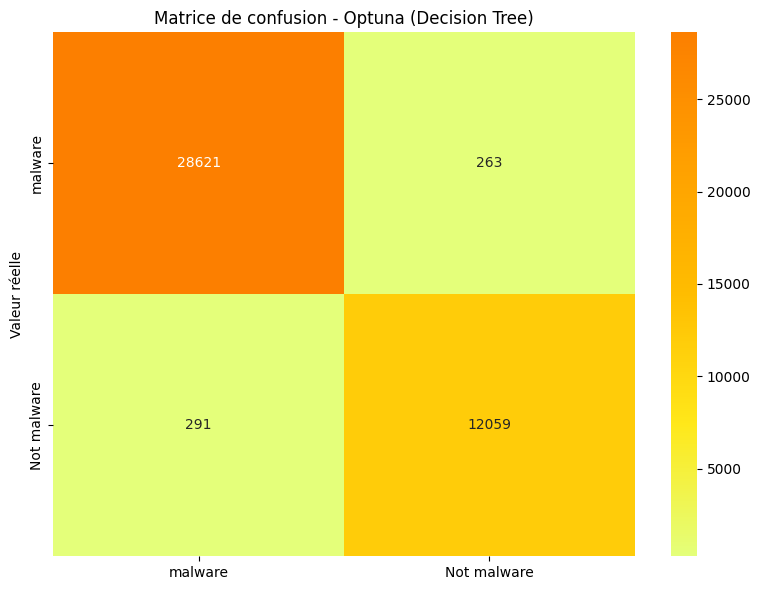

In [37]:
plt.figure(figsize=(8, 6))
sns.heatmap(optuna_conf_matrix, annot=True, fmt='d', xticklabels=['malware','Not malware'], yticklabels=['malware','Not malware'], cmap='Wistia' )
plt.ylabel('Valeur réelle')
plt.title('Matrice de confusion - Optuna (Decision Tree)')
plt.tight_layout()
plt.savefig('optuna_confusion_matrix.png')


# Ajout des résultats à la liste pour comparaison

In [38]:
all_results.append({
    'Méthode': 'Optuna',
    'F1 Score': optuna_f1,
    'Precision': optuna_precision,
    'Recall': optuna_recall,
    'Durée d\'exécution (s)': optuna_execution_time
})

In [39]:
print("\n--- Tableau comparatif des méthodes d'optimisation ---")


--- Tableau comparatif des méthodes d'optimisation ---


# Formatage pour un meilleur affichage

In [40]:
df_results = pd.DataFrame(all_results)

# Formatage pour un meilleur affichage
df_results['F1 Score'] = df_results['F1 Score'].map('{:.4f}'.format)
df_results['Precision'] = df_results['Precision'].map('{:.4f}'.format)
df_results['Recall'] = df_results['Recall'].map('{:.4f}'.format)
df_results['Durée d\'exécution (s)'] = df_results['Durée d\'exécution (s)'].map('{:.2f}'.format)

print(tabulate(df_results, headers='keys', tablefmt='pretty', showindex=False))

+--------------------------+----------+-----------+--------+-----------------------+
|         Méthode          | F1 Score | Precision | Recall | Durée d'exécution (s) |
+--------------------------+----------+-----------+--------+-----------------------+
| Base (sans optimisation) |  0.9873  |  0.9874   | 0.9873 |         0.00          |
|    RandomizedSearchCV    |  0.9860  |  0.9861   | 0.9860 |         18.72         |
|       GridSearchCV       |  0.9877  |  0.9877   | 0.9877 |         39.43         |
|          Optuna          |  0.9866  |  0.9866   | 0.9866 |         47.39         |
+--------------------------+----------+-----------+--------+-----------------------+


# Sauvegarde du tableau pour réutilisation

In [41]:
df_results.to_csv('resultats_comparatifs_optimisation.csv', index=False)


# Visualisation graphique des temps d'exécution

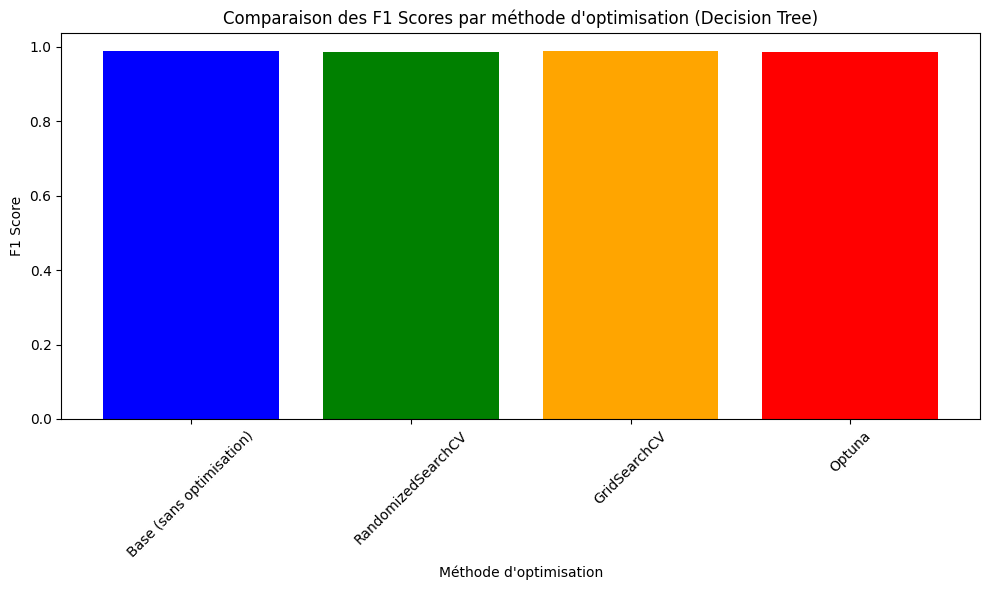

In [42]:
plt.figure(figsize=(10, 6))
bars = plt.bar(df_results['Méthode'], df_results['F1 Score'].astype(float), color=['blue', 'green', 'orange', 'red'])
plt.xlabel('Méthode d\'optimisation')
plt.ylabel('F1 Score')
plt.title('Comparaison des F1 Scores par méthode d\'optimisation (Decision Tree)')
plt.xticks(rotation=45)
plt.tight_layout()

# Ajout des valeurs sur les barres

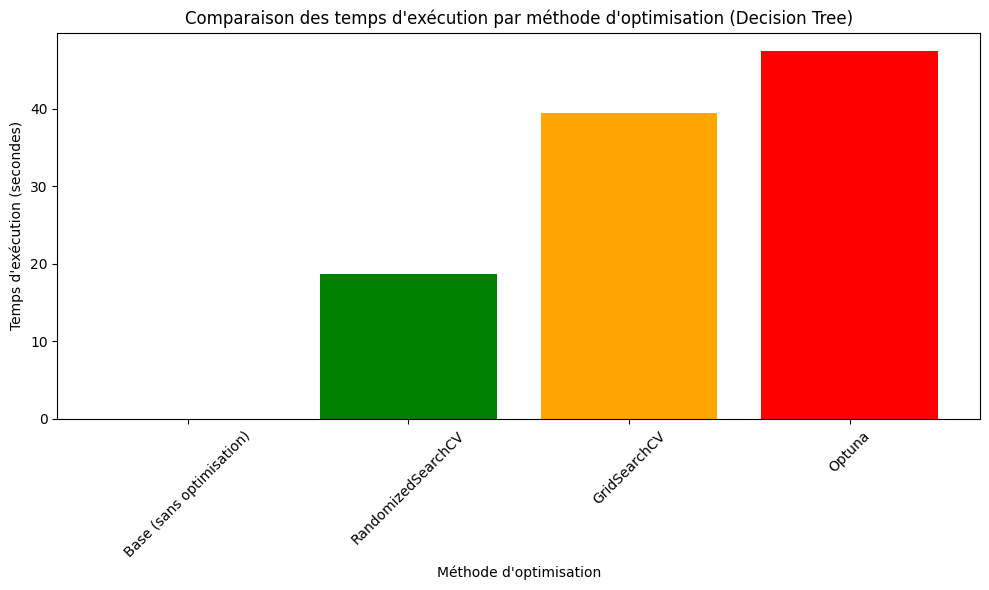

In [43]:
plt.figure(figsize=(10, 6))
bars = plt.bar(df_results['Méthode'], df_results['Durée d\'exécution (s)'].astype(float), color=['blue', 'green', 'orange', 'red'])
plt.xlabel('Méthode d\'optimisation')
plt.ylabel('Temps d\'exécution (secondes)')
plt.title('Comparaison des temps d\'exécution par méthode d\'optimisation (Decision Tree)')
plt.xticks(rotation=45)
plt.tight_layout()


# Visualisation comparative des matrices de confusion


Analyse terminée. Tous les résultats ont été sauvegardés.


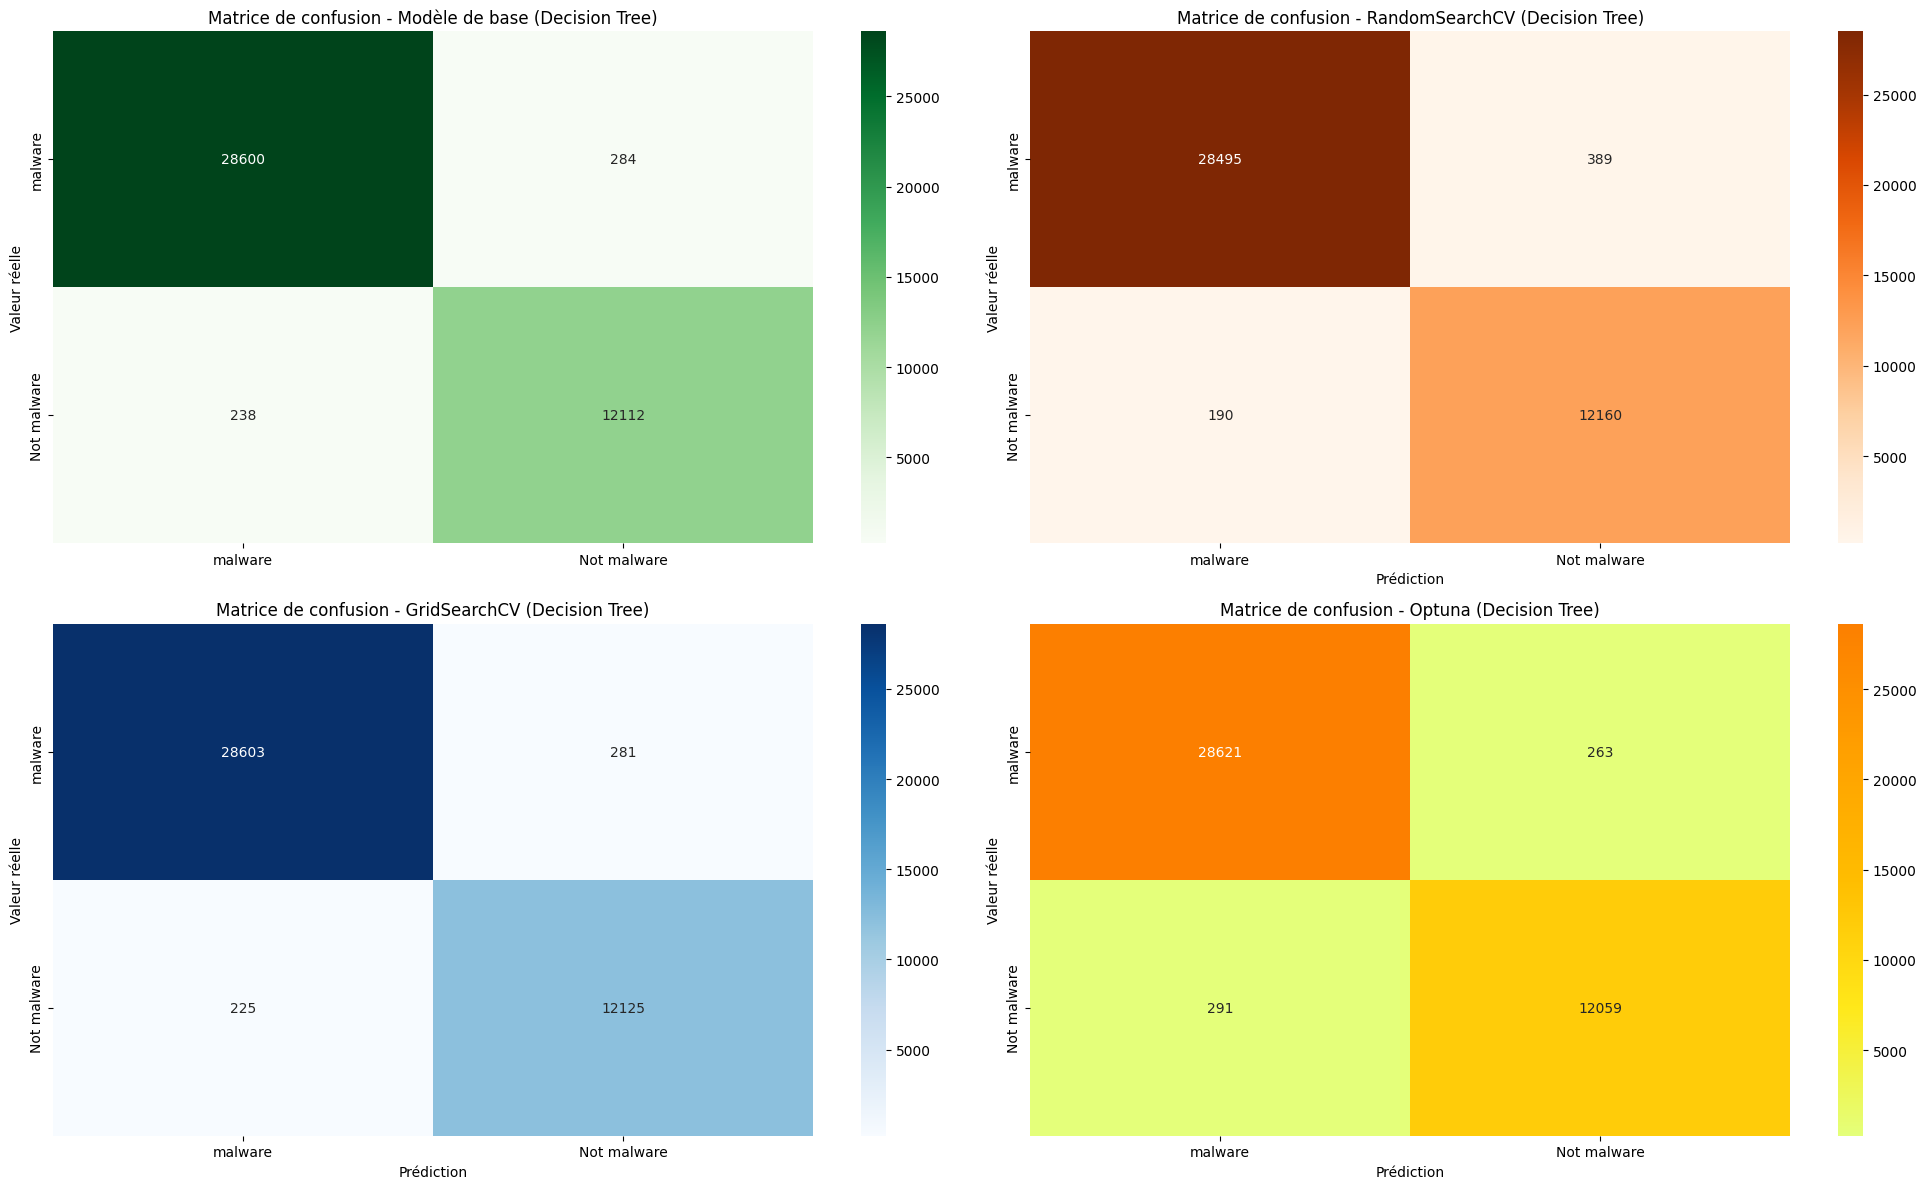

In [44]:
plt.figure(figsize=(20, 12))

plt.subplot(2, 2, 1)
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=['malware','Not malware'], yticklabels=['malware','Not malware'], cmap='Greens' )
plt.ylabel('Valeur réelle')
plt.title('Matrice de confusion - Modèle de base (Decision Tree)')

plt.subplot(2, 2, 2)
sns.heatmap(rs_conf_matrix, annot=True, fmt='d', xticklabels=['malware','Not malware'], yticklabels=['malware','Not malware'], cmap='Oranges' )
plt.xlabel('Prédiction')
plt.ylabel('Valeur réelle')
plt.title('Matrice de confusion - RandomSearchCV (Decision Tree)')

plt.subplot(2, 2, 3)
sns.heatmap(gs_conf_matrix, annot=True, fmt='d', xticklabels=['malware','Not malware'], yticklabels=['malware','Not malware'], cmap='Blues' )
plt.xlabel('Prédiction')
plt.ylabel('Valeur réelle')
plt.title('Matrice de confusion - GridSearchCV (Decision Tree)')

plt.subplot(2, 2, 4)
sns.heatmap(optuna_conf_matrix, annot=True, fmt='d', xticklabels=['malware','Not malware'], yticklabels=['malware','Not malware'], cmap='Wistia' )
plt.xlabel('Prédiction')
plt.ylabel('Valeur réelle')
plt.title('Matrice de confusion - Optuna (Decision Tree)')

plt.tight_layout()
plt.savefig('all_confusion_matrices_comparison.png')

print("\nAnalyse terminée. Tous les résultats ont été sauvegardés.")

Validation

In [46]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score
import numpy as np

# Définir le modèle
model = DecisionTreeClassifier(random_state=42)

# Définir une fonction de scoring personnalisée si nécessaire
f1_scorer = make_scorer(f1_score, average='macro')

# Validation croisée à 5 plis
cv_scores = cross_val_score(model, X, Y, cv=5, scoring=f1_scorer)

print("Scores F1 pour chaque fold :", cv_scores)
print("F1 score moyen :", np.mean(cv_scores))
print("Écart type :", np.std(cv_scores))

Scores F1 pour chaque fold : [0.98056735 0.98005471 0.92022421 0.90368745 0.99178017]
F1 score moyen : 0.9552627786482761
Écart type : 0.03598943476873911


In [49]:
model_random = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=5, scoring='f1_macro', random_state=42)
model_random.fit(x_train, y_train)

best_random = model_random.best_estimator_

# Validation croisée sur le modèle Random Search
cv_scores_random = cross_val_score(best_random, X, Y, cv=5, scoring=f1_scorer)

print("F1 scores (Random Search):", cv_scores_random)
print("F1 score moyen (Random Search):", np.mean(cv_scores_random))


F1 scores (Random Search): [0.98117099 0.97901655 0.93429965 0.90573018 0.98909027]
F1 score moyen (Random Search): 0.9578615274767752


In [51]:
best_grid = best_grid_model

cv_scores_grid = cross_val_score(best_grid, X, Y, cv=5, scoring=f1_scorer)

print("F1 scores (Grid Search):", cv_scores_grid)
print("F1 score moyen (Grid Search):", np.mean(cv_scores_grid))


F1 scores (Grid Search): [0.98157765 0.98097055 0.92894735 0.90981578 0.99139645]
F1 score moyen (Grid Search): 0.9585415551808436


In [54]:
def objective(trial):
    ...
    model = LogisticRegression(**params)
    model.fit(X_train, y_train)
    
    # Evaluation
    preds = model.predict(X_valid)
    score = f1_score(y_valid, preds, average='macro')
    
    # Enregistrement du modèle dans les attributs de l'essai
    trial.set_user_attr('best_model', model)

    return score
